In [2]:
from __future__ import print_function
import pandapower as pp
import pandapower.networks as pn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import stable_baselines
import pickle
from stable_baselines import DDPG
from scipy.stats import wilcoxon
import sys
import copy
sys.path.append('C:\\Users\\vegar\\Dropbox\\Master\\thesis.git')
from  gym_power.envs.active_network_env import ActiveEnv
import seaborn as sns
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib notebook


# I need to see the actions of the agent
The agent activates flexibility to help the net. Need to plot the actions of the agent togeather with solar irradiance and demand at each load.


<IPython.core.display.Javascript object>


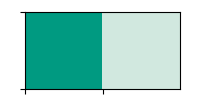

In [3]:
def nmbu_palette(color_path='C:\\Users\\vegar\\Dropbox\\Master\\thesis.git\\data'):
    """
    Createes list with rbg of nmbu colors. Can be fed to seaborn.set_palette()
    :return:
    """
    color_path += '\\nmbu_palette.csv'
    colorframe = pd.read_csv(color_path)
    colorframe = colorframe[['r', 'g', 'b']].values
    palette = [colorframe[k, :] for k in range(colorframe.shape[0])]
    return palette
palette = nmbu_palette()
line_colors = [palette[k] for k in [0,8]]
bar_colors = [palette[k] for k in [0,1]]
sns.palplot(bar_colors)

In [4]:
def stack_columns(df,columns):
    stacked = pd.DataFrame()
    values, labels = [], []
    for col in columns:
        values += list(df[col])
        labels += [col for _ in range(len(df))]
    stacked['Reward'] = values
    stacked[''] = labels
    return stacked
    

In [5]:
def pickle_savefig(fig,figname):
    matplotlib_name = 'figs/' + figname + '_plt.p'
    with open(matplotlib_name,'wb') as f:
        pickle.dump(fig,f)
    fig.savefig('figs/' + figname +'.png')
    
    
    
    

In [6]:
def read_pickle_fig(figname):
    with open('figs/'+figname +'_plt.p', 'rb') as f:
        fig = pickle.load(f)
    return fig

In [7]:
def find_load_names(sol_bus):
    nr_sol = 1
    nr_else = 1
    load_names = []
    for k in range(len(sol_bus)):
        if sol_bus[k]:
            load_names.append('sun {}'.format(nr_sol))
            nr_sol += 1
        else:
            load_names.append('load {}'.format(nr_else))
            nr_else += 1
    return load_names

In [8]:
def calc_hour(start_hour,time_step):
    return (start_hour + time_step) % 24

In [9]:
def simulate_day2(env,model, show_imbalance=False, show_solar=True, show_action=True,
                  show_demand=False,period=25):
    net = env.powergrid
    sol_bus = net.load['bus'].isin(net.sgen['bus'])
    actions = []
    t_steps = []
    flex_loads = []
    sols = []
    obs = env.reset()
    sol = env.solar_forecasts
    demand = env.demand_forecasts[0]
    names = find_load_names(sol_bus)
    hues = []
    for t_step in range(1,period):
        
        action,_ = model.predict(obs)
        obs, rewards, dones, info = env.step(action)
        
        if show_action:
            actions += list(action)
            hues += ['action' for _ in range(len(action))]
            t_steps += list(t_step*np.ones_like(action))
            flex_loads += names
        
        if show_solar:
            actions += list(sol[t_step-1]*np.ones_like(action))
            hues += ['sun' for _ in range(len(action))]
            t_steps += list(t_step*np.ones_like(action))
            flex_loads += names
        if show_imbalance:
            try:
                imbalance = env.calc_balance()/30000
            except AttributeError:
                imbalance = env.calc_imbalance()/30000
            actions += list(imbalance*np.ones_like(action))
            hues += ['imbalance' for _ in range(len(action))]
            t_steps += list(t_step*np.ones_like(action))
            flex_loads += names
            
        if show_demand:
            actions += list(demand[t_step-1]*np.ones_like(action))
            hues += ['demand' for _ in range(len(action))]
            t_steps += list(t_step*np.ones_like(action))
            flex_loads += names
            


    df = pd.DataFrame()
    df['actions'] = actions
    df['steps'] = t_steps
    df['load'] = flex_loads
    df[''] = hues
    return df

In [10]:
def data_from_subplot(ax, imbalance=False):
    actions = ax.lines[3].get_ydata()
    sun = ax.lines[4].get_ydata()
    balance = ax.lines[5].get_ydata()
    oneplot = pd.DataFrame()
    if imbalance:
        oneplot['Energy imbalance'] = balance
    oneplot['Solar irradiance'] = sun
    oneplot['Action'] = actions
    return oneplot

In [11]:
def change_hours(x,start=155):
    return x-start
def change_legend(x):
    if x == 'No agent':
        return 'No action'
    else:
        return x

## Import models

In [12]:
def load_env(model_name='flexible_load_first',seed=9):
#flexible_load_first, overnight, larger_margin_cost, discount_06, flex50

    params_name = model_name +'_params.p'
    model = DDPG.load('models/'+model_name)
    env = ActiveEnv(seed=seed)
    with open('models/' + params_name,'rb') as f:
        params = pickle.load(f)

    env.set_parameters(params)
    model.set_env(env)
    return model, env

In [21]:
def process_df(df,env,lines=['action','sun'],steps=range(8,33)):
    sol_bus = env.powergrid.load['bus'].isin(env.powergrid.sgen['bus'])
    load_name = dict(zip(find_load_names(sol_bus),range(18)))
    data = df[df['steps'].isin(steps)]
    data = data[data[''].isin(lines)]
    data['steps'] = data['steps'].apply(lambda x: change_hours(x,start=8))
    data['load'] = data['load'].apply(lambda x:load_name[x])
    data = data.rename(columns={'steps':'Hour'})#,'actions':'$\Delta P \; [\%]$'})
    
    
    
    return data
    


In [303]:
model, env = load_env()
df = simulate_day2(env,model, show_demand=True, show_imbalance=True, period=199)


Loading a model without an environment, this model cannot be trained until it has a valid environment.
setting up target updates ...
  target/pi/fc0/kernel:0 <- model/pi/fc0/kernel:0
  target/pi/fc0/bias:0 <- model/pi/fc0/bias:0
  target/pi/LayerNorm/beta:0 <- model/pi/LayerNorm/beta:0
  target/pi/LayerNorm/gamma:0 <- model/pi/LayerNorm/gamma:0
  target/pi/fc1/kernel:0 <- model/pi/fc1/kernel:0
  target/pi/fc1/bias:0 <- model/pi/fc1/bias:0
  target/pi/LayerNorm_1/beta:0 <- model/pi/LayerNorm_1/beta:0
  target/pi/LayerNorm_1/gamma:0 <- model/pi/LayerNorm_1/gamma:0
  target/pi/pi/kernel:0 <- model/pi/pi/kernel:0
  target/pi/pi/bias:0 <- model/pi/pi/bias:0
  target/qf/fc0/kernel:0 <- model/qf/fc0/kernel:0
  target/qf/fc0/bias:0 <- model/qf/fc0/bias:0
  target/qf/LayerNorm/beta:0 <- model/qf/LayerNorm/beta:0
  target/qf/LayerNorm/gamma:0 <- model/qf/LayerNorm/gamma:0
  target/qf/fc1/kernel:0 <- model/qf/fc1/kernel:0
  target/qf/fc1/bias:0 <- model/qf/fc1/bias:0
  target/qf/LayerNorm_1/beta:

In [307]:
def change_action_name(hue):
    if hue == 'actions':
        return 'demand change [%]'
    else:
        return hue
        

<IPython.core.display.Javascript object>


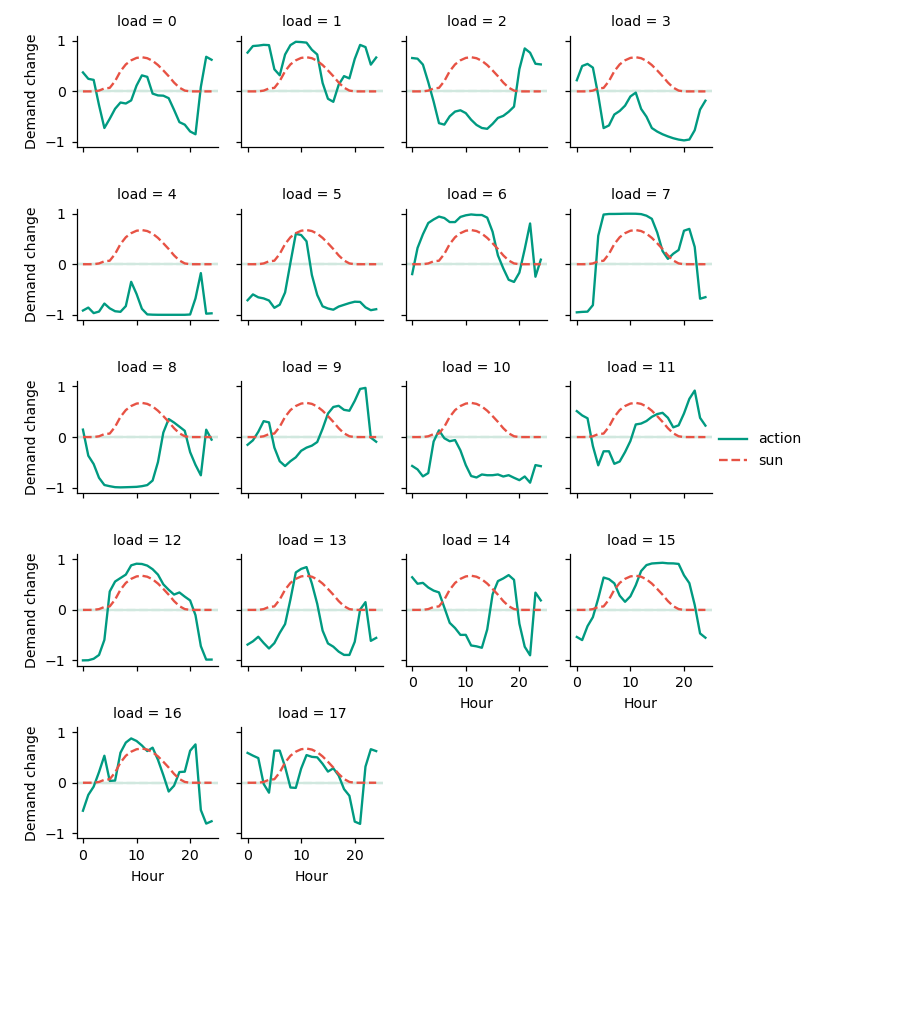

In [323]:
data = process_df(df,env)
data[''] = data[''].apply(lambda x:change_action_name(x))
d = {"ls" : ["-","--"]}
grid = sns.FacetGrid(data.rename(columns={'actions':'Demand change'}), col="load", hue="",
                     col_wrap=4, height=1.6, palette=line_colors, hue_kws=d)
grid.map(plt.axhline, y=0, ls=":", c=palette[1])

#grid.map(plt.plot, "Hour", 'actions')
grid.map(plt.plot, "Hour", 'Demand change')


grid.add_legend()


In [324]:
#pickle_savefig(grid,'configuration1')

<IPython.core.display.Javascript object>


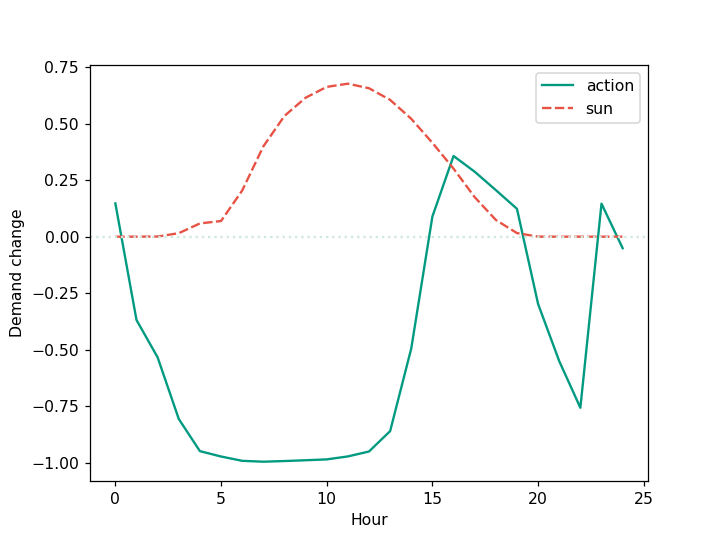

In [334]:
plt.rc('font', **{'size':10})

sns.set_palette(line_colors)
fig, ax = plt.subplots()
data = process_df(df.rename(columns={'actions':'Demand change'}),env)
data = data[data['load']==8]
sns.lineplot(x='Hour',y='Demand change',hue='',data=data, style='',ax=ax)
ax.axhline(y=0, c=palette[1],ls=':')


In [335]:
#pickle_savefig(fig,'configuration1_negative_actions')
#'configuration1_follows_sun'

In [283]:
@interact
def plot_load(ax_nr1=range(18),ax_nr2=range(18),period=(0,200)):
    plot1 = data_from_subplot(grid.axes[ax_nr1],imbalance=True)
    plot2 = data_from_subplot(grid.axes[ax_nr2],imbalance=True)

    fig, axes = plt.subplots(2)
    #axes.set_title(ax.get_title())
    #axes.set_title('Total energy imbalance')
    axes[0].set_xlabel('steps')
    axes[0].axhline(0,c=".5",ls='--')
    axes[1].axhline(0,c=".5",ls='--')
    #axes.set_ylabel('MWh')
    plot1[:period].plot(ax=axes[0])
    plot2[:period].plot(ax=axes[1])
    plt.tight_layout()


interactive(children=(Dropdown(description='ax_nr1', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14…

In [469]:
df = simulate_day2(env,model, show_demand=True, show_imbalance=True, period=199)

data = process_df(df,lines=['imbalance'],steps=range(200))
data['actions'] *= 30


<IPython.core.display.Javascript object>


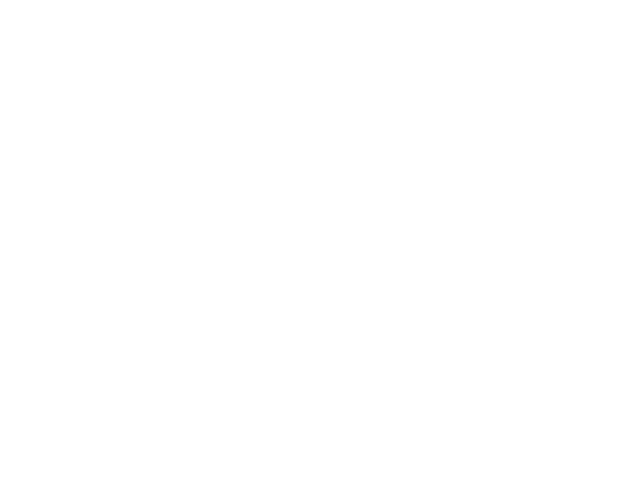

In [470]:
fig, ax = plt.subplots()
sns.lineplot(x='Hour',y='actions', data=data, ax=ax, estimator=np.sum, ci=None)
ax.set_ylabel('Energy imbalance [MWh]')
plt.tight_layout()

In [471]:
#pickle_savefig(fig,'configuration1_imbalance')

In [253]:
period=199
#model, env = load_env(seed=9)
env1 = ActiveEnv(seed=9)
net = env1.powergrid
actions = []
t_steps = []
flex_loads = []
obs = env1.reset()
sol = env1.solar_forecasts
hues = []
env1.set_parameters({'flexibility':0.25,
                   'solar_scale':1.2,
                   'reactive_power':False})
env2 = copy.deepcopy(env1)
env2.set_parameters({'reactive_power':True})
env2.solar_forecasts = env1.solar_forecasts 
env2.demand_forecasts = env1.demand_forecasts
env3 = copy.deepcopy(env1)
env3.do_action = False
legend_map = {0:'Active',1:'- 25 % demand', 2: 'No action'}


action = -np.ones(18)
for t_step in range(1,period):
    for i, env in enumerate([env1, env2, env3]):
        obs, rewards, dones, info = env.step(action)
        voltage = env.powergrid.res_bus.vm_pu
        actions += list(voltage)
        hues += [legend_map[i] for _ in range(len(voltage))]
        t_steps += list(t_step*np.ones_like(voltage))
        flex_loads += list(range(len(voltage)))

df = pd.DataFrame()
df['Voltage [pu]'] = actions
df['Hour'] = t_steps
df['Load'] = flex_loads
df[''] = hues

<IPython.core.display.Javascript object>


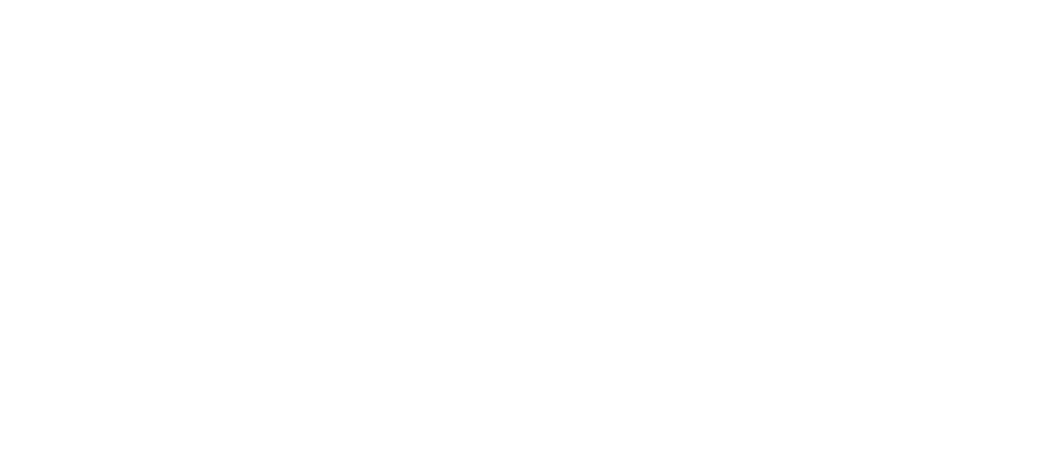

In [254]:
sns.set(style="ticks")
grid = sns.FacetGrid(df, col="Load", hue="",
                     col_wrap=6, height=1.5)


grid.map(plt.axhline, y=1, ls=":", c=".5")

grid.map(plt.plot, "Hour", "Voltage [pu]")
grid.add_legend()



In [227]:
@interact
def plot_voltage(bus_nr=list(range(15))[::-1]):
    data = df[df['Load']== bus_nr]
    fig, ax = plt.subplots()
    sns.lineplot(x="Hour", y="Voltage [pu]", data=data, ax=ax, hue='')
    

interactive(children=(Dropdown(description='bus_nr', options=(14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0…

<IPython.core.display.Javascript object>


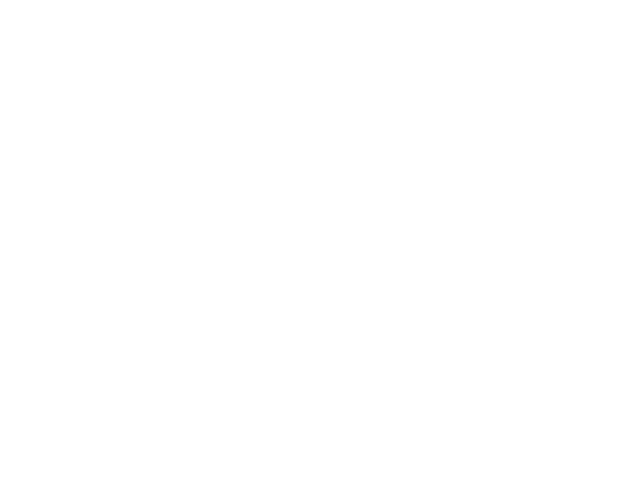

Text(0.5, 0, 'Hour of the day')

In [258]:
sns.set_palette(line_colors)
data = df[df['Load']== 8]
data = data[data[''].isin(['No action', '- 25 % demand'])]
data = data[data['Hour'].isin(range(73,97))]
data[''] = data[''].apply(lambda x:change_legend(x))
data['Hour'] = data['Hour'].apply(lambda x:change_hours(x,start=73))
fig, ax = plt.subplots()
sns.lineplot(x="Hour", y="Voltage [pu]", data=data, ax=ax, hue='',style='')
ax.set_xlabel('Hour of the day')

In [259]:
#pickle_savefig(fig,'decrease_demand_voltage')

## Line capacity effect

In [13]:
period=199
#model, env = load_env(seed=9)
env1 = ActiveEnv(seed=9)
net = env1.powergrid
actions = []
t_steps = []
flex_loads = []
obs = env1.reset()
sol = env1.solar_forecasts
hues = []
env1.set_parameters({'flexibility':0.25,
                   'solar_scale':1,
                   'reactive_power':False})
env2 = copy.deepcopy(env1)
env2.set_parameters({'reactive_power':True})
env2.solar_forecasts = env1.solar_forecasts 
env2.demand_forecasts = env1.demand_forecasts
env3 = copy.deepcopy(env1)
env3.do_action = False
legend_map = {0:'Active',1:'+25 % demand', 2: 'No action'}


action = np.ones(18)
#action[[0,10]] = -1

for t_step in range(1,period):

    #action,_ = model.predict(obs)
    action2 = np.ones(18)
    action2[[0,10]] = -1
    
    for i, env in enumerate([env1, env2, env3]):
        obs, rewards, dones, info = env.step(action)
        current = env.powergrid.res_line.loading_percent
        actions += list(current)
        hues += [legend_map[i] for _ in range(len(current))]
        t_steps += list(t_step*np.ones_like(current))
        flex_loads += list(range(len(current)))


df = pd.DataFrame()
df['Line capacity [%]'] = actions
df['Hour'] = t_steps
df['Line'] = flex_loads
df[''] = hues

<IPython.core.display.Javascript object>


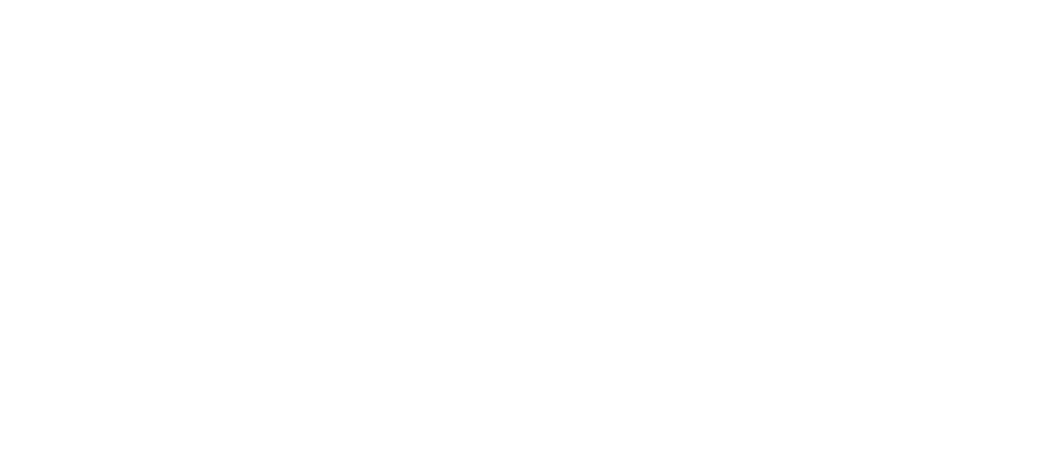

In [261]:
sns.set(style="ticks")
grid = sns.FacetGrid(df, col="Line", hue="",
                     col_wrap=6, height=1.5)


grid.map(plt.axhline, y=1, ls=":", c=".5")

grid.map(plt.plot, "Hour", "Line capacity [%]")
grid.add_legend()



In [262]:
@interact
def plot_current(line_nr=list(range(15))):
    data = df[df['Line']== line_nr]
    fig, ax = plt.subplots()
    sns.lineplot(x="Hour", y="Line capacity [%]", data=data, ax=ax, hue='')
    


interactive(children=(Dropdown(description='line_nr', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

<IPython.core.display.Javascript object>


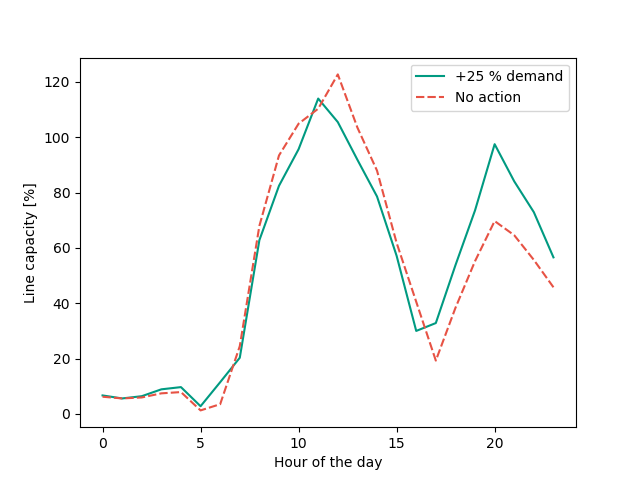

Text(0.5, 0, 'Hour of the day')

In [17]:
sns.set_palette(line_colors)
data = df[df['Line']== 0]
data = data[data[''].isin(['No action','+25 % demand'])]
data = data[data['Hour'].isin(range(25,49))]
data['Hour'] = data['Hour'].apply(lambda x:change_hours(x, start=25))
fig, ax = plt.subplots()
sns.lineplot(x="Hour", y="Line capacity [%]", data=data,
             ax=ax, hue='',style='')
ax.set_xlabel('Hour of the day')

In [18]:
#pickle_savefig(fig,'increase_demand_current')

## See the difference in reward between agent and no-agent

In [144]:
for reward in ['voltage','current']:
    period=100000
    model, env = load_env(seed=9) #seed 5: heavy sun, 9: weak sun
    env.set_parameters({'reward_terms': [reward],
                   'demand_std':0.03,
                   'solar_std':0.03,
                    'reactive_power':True})
    rewards, t_steps, hues, hours = [], [], [], []
    obs = env.reset()

    env2 = copy.deepcopy(env)
    env2.do_action = False
    sol = env.solar_forecasts
    demand = env.demand_forecasts[0]

    show_sun, show_demand = True, True
    for t_step in range(1,period):

        action,_ = model.predict(obs)
        obs1, reward1, dones1, info1 = env.step(action)
        obs2, reward2, dones2, info2 = env2.step(action)

        current_step = env._current_step
        hour = calc_hour(env._episode_start_hour,current_step)
            

        if current_step == 0:
            sol = env.solar_forecasts
            demand = env.demand_forecasts[0]


        rewards.append(reward1)
        hues.append('Agent')
        t_steps.append(t_step)
        hours.append(hour)

        rewards.append(reward2)
        hues.append('No agent')
        t_steps.append(t_step)
        hours.append(hour)



        if show_sun:    
            rewards.append(sol[env._current_step-1])
            hues.append('Sun')
            t_steps.append(t_step)
            hours.append(hour)

        if show_demand:
            rewards.append(demand[env._current_step-1])
            hues.append('Demand')
            t_steps.append(t_step)
            hours.append(hour)

    df = pd.DataFrame()
    df['Reward'] = rewards
    df['Hours'] = t_steps
    df['Hour in the day'] = hours
    df[''] = hues
    df.to_csv('data/config1_random_hour_{}.csv'.format(reward),index=False)

Loading a model without an environment, this model cannot be trained until it has a valid environment.
setting up target updates ...
  target/pi/fc0/kernel:0 <- model/pi/fc0/kernel:0
  target/pi/fc0/bias:0 <- model/pi/fc0/bias:0
  target/pi/LayerNorm/beta:0 <- model/pi/LayerNorm/beta:0
  target/pi/LayerNorm/gamma:0 <- model/pi/LayerNorm/gamma:0
  target/pi/fc1/kernel:0 <- model/pi/fc1/kernel:0
  target/pi/fc1/bias:0 <- model/pi/fc1/bias:0
  target/pi/LayerNorm_1/beta:0 <- model/pi/LayerNorm_1/beta:0
  target/pi/LayerNorm_1/gamma:0 <- model/pi/LayerNorm_1/gamma:0
  target/pi/pi/kernel:0 <- model/pi/pi/kernel:0
  target/pi/pi/bias:0 <- model/pi/pi/bias:0
  target/qf/fc0/kernel:0 <- model/qf/fc0/kernel:0
  target/qf/fc0/bias:0 <- model/qf/fc0/bias:0
  target/qf/LayerNorm/beta:0 <- model/qf/LayerNorm/beta:0
  target/qf/LayerNorm/gamma:0 <- model/qf/LayerNorm/gamma:0
  target/qf/fc1/kernel:0 <- model/qf/fc1/kernel:0
  target/qf/fc1/bias:0 <- model/qf/fc1/bias:0
  target/qf/LayerNorm_1/beta:

In [86]:
#df.to_csv('data/confi2g_current.csv',index=False)

In [298]:
df = pd.read_csv('data/config1_random_hour_voltage.csv')
df = df.rename(columns={'Unnamed: 3':''})

In [299]:
rewards = df[df[''].isin(['Agent','No agent'])]
rewards = rewards[rewards['Reward'] < 0]
rewards['Reward'] *= -1
stats = rewards[['','Reward']].groupby(['']).describe()['Reward']
stats
#stats.iloc[:,:-1].to_csv('data/stats_config1_current.csv',float_format='%.3f')
cols = [c for c in stats if c !='min']
stats[cols]
#stats[cols].to_csv('data/stats_config1_current.csv',float_format='%.3f')

,count,mean,std,25%,50%,75%,max
,,,,,,,
Agent,7253.0,0.034647,0.036635,0.006305,0.021402,0.052223,0.236930
No agent,8804.0,0.037495,0.039104,0.006848,0.022765,0.057415,0.227246


In [271]:
k = rewards[['','Reward']].groupby(['']).sum()
k.iloc[0]/k.iloc[1]
#k

Reward    1.135487
dtype: float64

In [201]:
7253/8804

0.8238300772376193

In [173]:
cat1 = df[df[''] == 'Agent']['Reward'].values
cat2 = df[df[''] == 'No agent']['Reward'].values
wilcoxon(cat1, cat2)

WilcoxonResult(statistic=726.0, pvalue=1.3456498666764192e-10)

In [174]:
stats['count']*stats['mean']


Agent      -16.982571
No agent   -15.380907
dtype: float64

In [115]:
mean_agent =(505.9/9022)
mean_noagent = (522.5/9823) 
mean_agent/mean_noagent

1.0541919751718023

## Period the agent is good

<IPython.core.display.Javascript object>


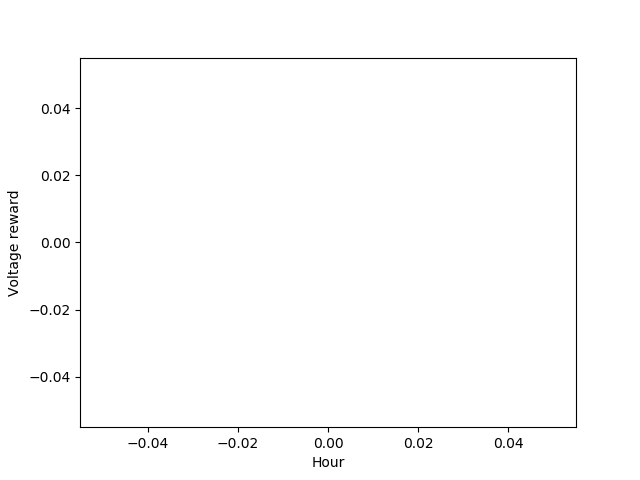

Text(0.5, 0, 'Hour')

In [126]:
sns.set_palette(line_colors[::-1])
rewards = df[df[''].isin(['Agent','No agent'])] #voltage: (15600,16000)
data = rewards
data = data[data['Hours'].isin(range(15665,15800))]
data['Hours'] = data['Hours'].apply(lambda x:change_hours(x, start=15665))
fig, ax = plt.subplots()
sns.lineplot(x="Hours", y="Reward", data=data, ax=ax, hue='')
ax.set_ylabel('Voltage reward')
ax.set_xlabel('Hour')

In [187]:
#pickle_savefig(fig,'config1_400hour_good_voltage')

In [73]:
#stats = data[data['Reward'] < 0].groupby('')['Reward'].describe()
stats  = data[['','Reward']].groupby([''])['Reward'].describe()
stats
#stats.iloc[:,:-1].to_csv('data/config1_400hour_good_voltage.csv',float_format='%.3f')


,count,mean,std,min,25%,50%,75%,max
,,,,,,,,
Agent,135.0,-0.004209,0.016608,-0.110966,0.0,0.0,0.0,0.0
No agent,135.0,-0.007566,0.025743,-0.150432,0.0,0.0,0.0,0.0


## Periods the agent is bad in terms of voltage
The agent has not learned to cope with high solar power production, period with high solar production have been found manually

<IPython.core.display.Javascript object>


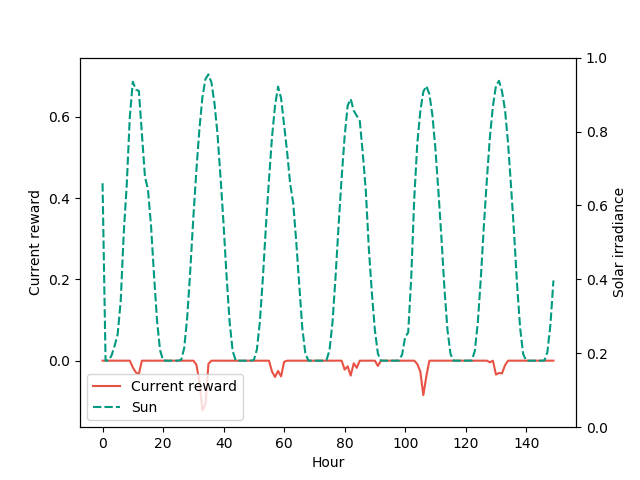

Text(0, 0.5, 'Solar irradiance')

In [36]:
rewards = df[df[''].isin(['Agent','Sun'])] #current (14570,14640), voltage (9800,9950)
data = rewards
data = data[data['Hours'].isin(range(9800,9950))]
data['Hours'] = data['Hours'].apply(lambda x:change_hours(x, start=9800))
data[''] = data[''].apply(lambda x: 'Current reward' if x == 'Agent' else x)
fig, ax = plt.subplots()
sns.lineplot(x="Hours", y="Reward", data=data, ax=ax, hue='',style='')
ax.set_ylabel('Current reward')
ax.set_xlabel('Hour')
ax2 = plt.twinx()
ax2.set_ylabel('Solar irradiance')

In [177]:
#pickle_savefig(fig,'config1_bad_current')


In [37]:
stats = data[data['Reward'] < 0].groupby('')['Reward'].describe()
stats
#stats.iloc[:,:-1].to_csv('data/config1_150hour_bad_voltage.csv',float_format='%.3f')

,count,mean,std,min,25%,50%,75%,max
,,,,,,,,
Current reward,31.0,-0.028637,0.029138,-0.1224,-0.03549,-0.025287,-0.008784,-0.000048


## Distribution in critical hours

In [279]:

agent = df[df[''] == 'Agent']

normal = df[df[''] == 'No agent']
bad_normal = normal[normal['Reward'] < 0]
bad_hours = bad_normal['Hours']
bad_agent = agent[agent['Hours'].isin(bad_hours.values)]
bad_agent['No agent'] = bad_normal['Reward'].values
bad_agent['normal_hours'] = bad_hours.values
bad_agent = bad_agent.rename(columns={'Reward':'Agent'})
assert all(bad_agent['normal_hours'] == bad_agent['Hours'])

<IPython.core.display.Javascript object>


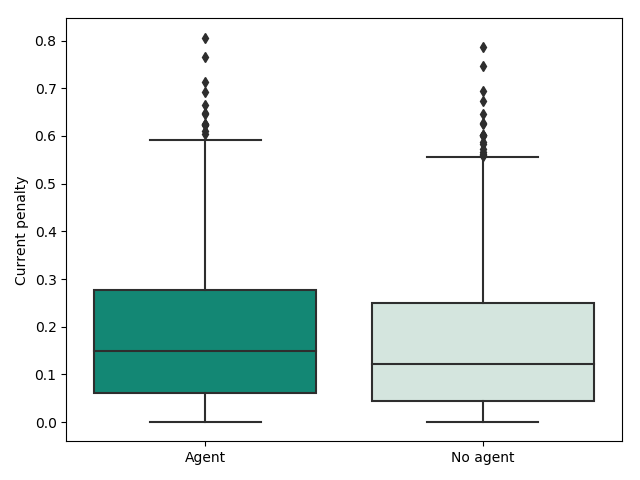

In [281]:
sns.set_palette(palette)
stacked = stack_columns(bad_agent,['Agent', 'No agent'])
stacked['Reward'] *= -1
fig, ax = plt.subplots()
sns.boxplot(x='', y="Reward", data=stacked, ax=ax)
ax.set_ylabel('Current penalty')
plt.tight_layout()

In [282]:
#pickle_savefig(fig, 'config1_current_boxplot')

In [76]:
 (118.3-115.7) /118.3

0.02197802197802193

In [212]:
stats = stacked.groupby('')['Reward'].describe()

#stats.iloc[:,:-1].to_csv('data/config1_voltage_critical.csv',float_format='%.3f')
cols = [c for c in stats if c !='min']
stats[cols]

#stats[cols].to_csv('data/config1_voltage_critical.csv',float_format='%.3f')



## T-test to see find difference

In [41]:
cat1 = bad_agent['Agent']
cat2 = bad_agent['No agent']
wilcoxon(cat1, cat2)

WilcoxonResult(statistic=11553002.0, pvalue=3.2131645824448124e-236)

## Sort rewards of the agent

<IPython.core.display.Javascript object>


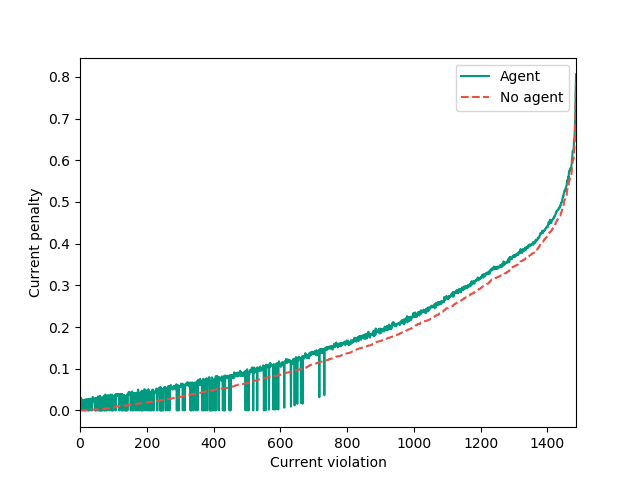

Text(0, 0.5, 'Current penalty')

In [284]:
sns.set_palette(line_colors)
fig, ax = plt.subplots()
sorted_agent = bad_agent.sort_values(by='No agent',ascending=False)
sorted_agent = sorted_agent.reset_index()
sorted_agent[['Agent','No agent']] *= -1
sorted_agent.plot(y=['Agent','No agent'],ax=ax, style=['-','--'])
ax.set_xlabel('Current violation')
ax.set_ylabel('Current penalty')

In [285]:
#pickle_savefig(fig,'config1_sorted_current')

In [167]:
data.quantile(0.86)

Agent       0.0
No agent    0.0
Name: 0.86, dtype: float64

In [286]:
data = sorted_agent[['Agent','No agent']]
data[data['Agent'] < data['No agent']].describe()

,Agent,No agent
count,134.000000,134.000000
mean,0.001321,0.030681
std,0.005154,0.029654
min,0.000000,0.000012
25%,0.000000,0.006420
50%,0.000000,0.020149
75%,0.000000,0.047471
max,0.036559,0.119104


In [225]:
0.017006/3.881966e-02

0.43807699500716907

In [287]:
(data['Agent'] < data['No agent']).mean()

0.09011432414256892

<IPython.core.display.Javascript object>


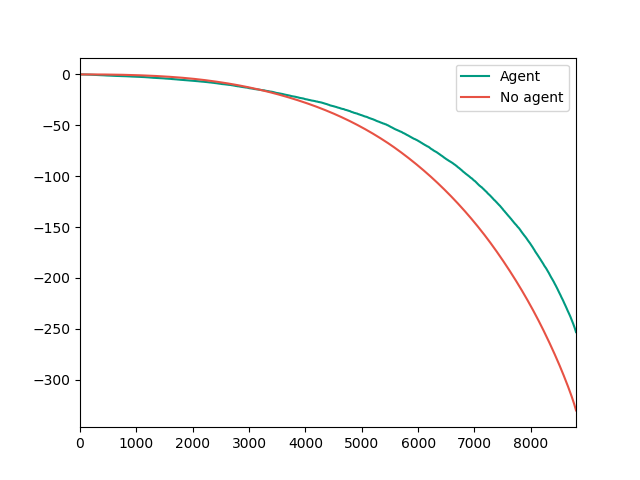

In [46]:
data.cumsum().plot()

## Trained agent in non-critical periods

<IPython.core.display.Javascript object>


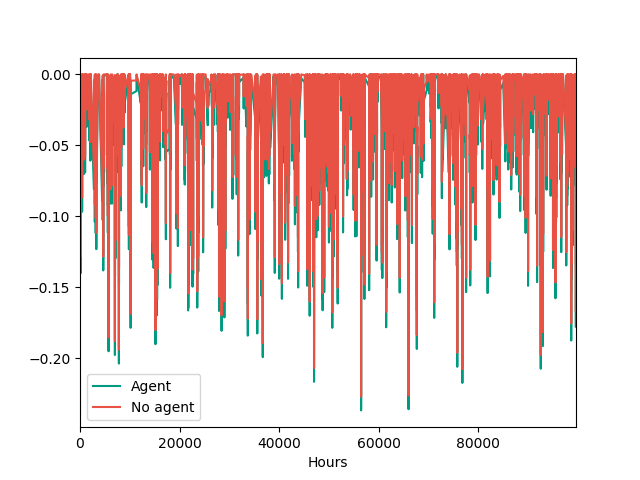

In [232]:
agent = df[df[''] == 'Agent']

normal = df[df[''] == 'No agent']
data = agent[['Hours']].reset_index(drop=True)
data['Agent'] = agent['Reward'].values
data['No agent'] = normal['Reward'].values
assert all(data['Hours'].values == normal['Hours'].values)

worse = data[data['Agent'] < data['No agent']]
worse.plot(x='Hours')

In [424]:
(normal['Reward'] == 0).mean()

1.0

## Non critical hours when the normal operation give no penalty
Most of the time the safety margins are not violated. How is the trained agent behaving in these hours?

In [233]:

agent = df[df[''] == 'Agent']

normal = df[df[''] == 'No agent']
bad_normal = normal[normal['Reward'] == 0]
bad_hours = bad_normal['Hours']
bad_agent = agent[agent['Hours'].isin(bad_hours.values)]
bad_agent['No agent'] = bad_normal['Reward'].values
bad_agent['normal_hours'] = bad_hours.values
bad_agent = bad_agent.rename(columns={'Reward':'Agent'})
assert all(bad_agent['normal_hours'] == bad_agent['Hours'])
data = bad_agent[['Agent','No agent']]

<IPython.core.display.Javascript object>


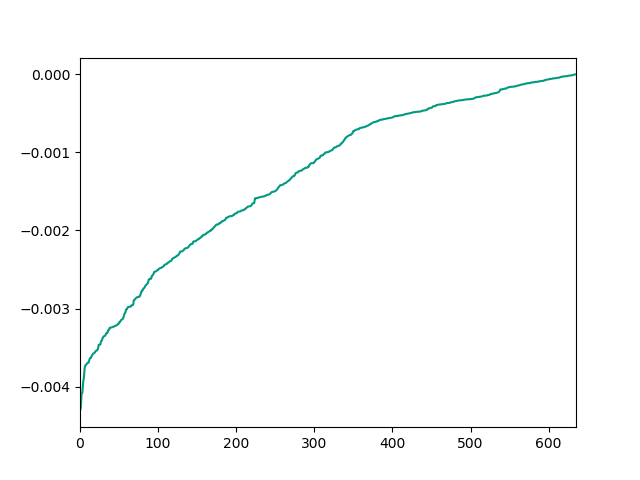

In [242]:
fig, ax = plt.subplots()
data[data['Agent'] < data['No agent']]['Agent'].sort_values().reset_index(drop=True).plot()

In [235]:
no_agent.groupby(no_agent['Reward'] < 0)['Reward'].describe()

,count,mean,std,min,25%,50%,75%,max
Reward,,,,,,,,
False,91195.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
True,8804.0,-0.037495,0.039104,-0.227246,-0.057415,-0.022765,-0.006848,-9.537289e-07


In [239]:
1-8804.0/(91195 + 8804.0)

0.9119591195911959

<IPython.core.display.Javascript object>


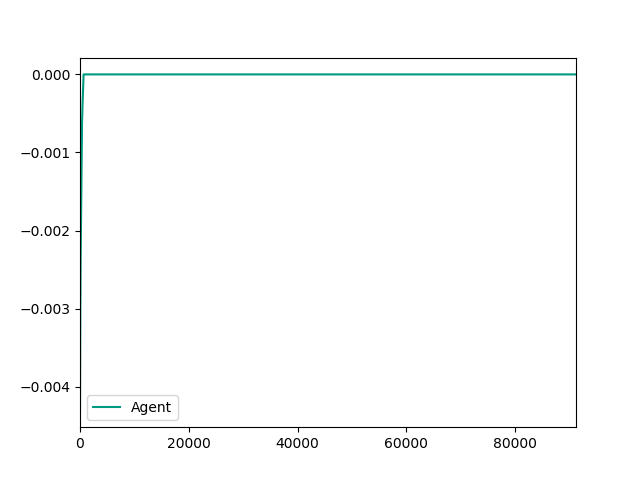

In [237]:
bad_agent[['Agent','No agent']].sort_values(by='Agent').reset_index().plot(y='Agent')

In [240]:
bad_agent[bad_agent['Agent'] < 0].describe()

,Agent,Hours,Hour in the day,No agent,normal_hours
count,636.000000,636.000000,636.000000,636.0,636.000000
mean,-0.001287,53353.294025,12.125786,0.0,53353.294025
std,0.001077,28800.798358,1.907275,0.0,28800.798358
min,-0.004302,19.000000,8.000000,0.0,19.000000
25%,-0.002054,29567.250000,11.000000,0.0,29567.250000
50%,-0.000997,55658.500000,12.000000,0.0,55658.500000
75%,-0.000357,75878.750000,14.000000,0.0,75878.750000
max,-0.000003,99517.000000,23.000000,0.0,99517.000000


In [241]:
636/91195

0.006974066560666703

### Energy imbalance
Inspect rewards from energy imbalance

In [130]:
#df = pd.read_csv('data/450k_full_hour_imbalance.csv')
#df = df.rename(columns={'Unnamed: 3':''})
#imbalance = df[df['']=='Agent']

In [132]:
imbalance.describe()

,Reward,Hours,Hour in the day
count,5649.000000,5649.000000,5649.000000
mean,-0.000402,2825.000000,11.489644
std,0.000021,1630.870167,6.922907
min,-0.000444,1.000000,0.000000
25%,-0.000408,1413.000000,5.000000
50%,-0.000403,2825.000000,11.000000
75%,-0.000398,4237.000000,17.000000
max,-0.000004,5649.000000,23.000000


In [133]:
imbalance['Reward'].sum()

-2.2704886801795596

In [134]:
imbalance[imbalance['Reward'] >-0.1].describe()

,Reward,Hours,Hour in the day
count,5649.000000,5649.000000,5649.000000
mean,-0.000402,2825.000000,11.489644
std,0.000021,1630.870167,6.922907
min,-0.000444,1.000000,0.000000
25%,-0.000408,1413.000000,5.000000
50%,-0.000403,2825.000000,11.000000
75%,-0.000398,4237.000000,17.000000
max,-0.000004,5649.000000,23.000000


<IPython.core.display.Javascript object>


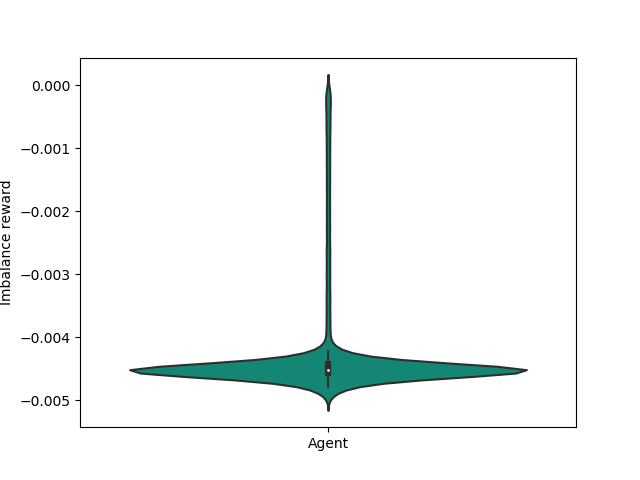

Text(0, 0.5, 'Imbalance reward')

In [82]:
fig,ax = plt.subplots()
sns.violinplot(x='',y='Reward',data=imbalance, ax=ax, palette=palette)
ax.set_ylabel('Imbalance reward')

In [274]:
#pickle_savefig(fig,'config1_imbalance_reward')

## Plot error by hour of the day
make boxplot for each hour of the day that show error distribution

In [300]:
agent = df[df[''] =='Agent']
no_agent = df[df[''] =='No agent']
bad_normal = no_agent[no_agent['Reward'] < 0]
bad_hours = bad_normal['Hours']
bad_agent = agent[agent['Hours'].isin(bad_hours.values)]

<IPython.core.display.Javascript object>


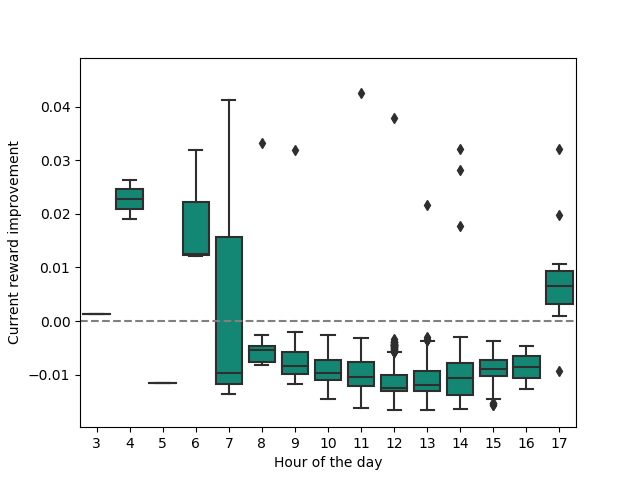

Text(0, 0.5, 'Current reward improvement')

In [301]:
assert all(bad_agent['Hours'].values == bad_normal['Hours'].values)
diff = pd.DataFrame()
diff['Improvement'] = bad_agent['Reward'].values - bad_normal['Reward'].values
diff['Hour'] = bad_agent['Hour in the day'].values
zero_data = []
for h in range(7,24):
    if h not in set(diff['Hour']):
        zero_data.append({'Hour':h,'Improvement':0})

if len(zero_data) > 0:
    diff = diff.append(zero_data)


fig, axes = plt.subplots()
sns.boxplot(x='Hour', y="Improvement", data=diff, ax=axes, color=palette[0])
axes.axhline(0,c=".5",ls='--')
axes.set_xlim(2.5,17.5) #V: 7.4,22.5, I :(3.5,17.5)
axes.set_xlabel('Hour of the day')
axes.set_ylabel('Current reward improvement')


In [293]:
#pickle_savefig(fig,'config1_improvement_current')

In [302]:
hours = diff.groupby(by='Hour').describe()
hours
hours.cumsum()/hours.sum()[0]

Improvement                                                      \
           count          mean       std           min           25%   
Hour                                                                   
0       0.000114 -1.158988e-06       NaN -1.158988e-06 -1.158988e-06   
1       0.000227 -2.318916e-06       NaN -2.318916e-06 -2.318916e-06   
2       0.000454 -6.300068e-07  0.000004 -3.213346e-06 -1.921676e-06   
3       0.000568 -4.892341e-07       NaN -3.072573e-06 -1.780904e-06   
4       0.000795  2.093513e-06  0.000004 -9.049254e-07  5.942936e-07   
5       0.000909  7.776379e-07       NaN -2.220800e-06 -7.215811e-07   
6       0.001249  2.926189e-06  0.000006 -8.346373e-07  6.851157e-07   
7       0.001590  3.598063e-06  0.000009 -2.388118e-06 -6.464003e-07   
8       0.005452  3.051063e-06  0.000010 -3.317951e-06 -1.519430e-06   
9       0.030441  2.177299e-06  0.000010 -4.648429e-06 -2.640486e-06   
10      0.085529  1.142592e-06  0.000010 -6.311942e-06 -3.899474e-06   
11      0.168219  2.078232e-08  0.000011 -8.147531e-06 -5.268819e-06   
12      0.249318 -1.277237e-06  0.000011 -1.004250e-05 -6.748051e-06   
13      0.329396 -2.544589e-06  0.000012 -1.192578e-05 -8.241162e-06   
14      0.382326 -3.719972e-06  0.000012 -1.379575e-05 -9.805393e-06   
15      0.398682 -4.743566e-06  0.000012 -1.557459e-05 -1.097741e-05   
16      0.398910 -5.718808e-06  0.000013 -1.700650e-05 -1.218099e-05   
17      0.400500 -4.844362e-06  0.000014 -1.807396e-05 -1.181616e-05   
18      0.436393 -2.665058e-06  0.000016 -1.946582e-05 -1.112686e-05   
19      0.568492 -1.858205e-07  0.000017 -1.946415e-05 -1.028464e-05   
20      0.792481  2.543635e-06  0.000019 -2.057665e-05 -9.293805e-06   
21      0.991368  4.844815e-06  0.000021 -2.057626e-05 -8.647025e-06   
22      0.999659  5.936083e-06  0.000022 -2.188698e-05 -8.468149e-06   
23      1.000000  6.567391e-06  0.000025 -2.347115e-05 -9.803355e-06   

                                            
               50%           75%       max  
Hour                                        
0    -1.158988e-06 -1.158988e-06 -0.000001  
1    -2.318916e-06 -2.318916e-06 -0.000002  
2    -6.300068e-07  6.616626e-07  0.000002  
3    -4.892341e-07  8.024353e-07  0.000002  
4     2.093513e-06  3.592732e-06  0.000005  
5     7.776379e-07  2.276857e-06  0.000004  
6     2.204869e-06  4.806603e-06  0.000007  
7     1.095317e-06  6.591153e-06  0.000012  
8     4.715081e-07  6.053214e-06  0.000016  
9    -4.898378e-07  5.386757e-06  0.000019  
10   -1.590712e-06  4.565477e-06  0.000019  
11   -2.781378e-06  3.687016e-06  0.000024  
12   -4.193403e-06  2.533566e-06  0.000028  
13   -5.541754e-06  1.470524e-06  0.000031  
14   -6.752820e-06  5.760241e-07  0.000034  
15   -7.760809e-06 -2.450204e-07  0.000034  
16   -8.736052e-06 -9.919278e-07  0.000033  
17   -7.996628e-06  6.351834e-08  0.000037  
18   -5.824790e-06  3.715927e-06  0.000042  
19   -3.184392e-06  7.827890e-06  0.000047  
20   -1.129408e-07  1.221179e-05  0.000052  
21    2.084135e-06  1.614514e-05  0.000057  
22    2.644603e-06  1.800709e-05  0.000061  
23    1.558367e-06  1.974614e-05  0.000066

In [54]:
diff.groupby(by='Hour').describe()[17:23].sum()

Improvement  count    5289.000000
             mean        0.097996
             std         0.072401
             min        -0.039084
             25%         0.032688
             50%         0.097171
             75%         0.158357
             max         0.225661
dtype: float64

## Nominal load values
See the difference in nominal loads between the loads

<IPython.core.display.Javascript object>


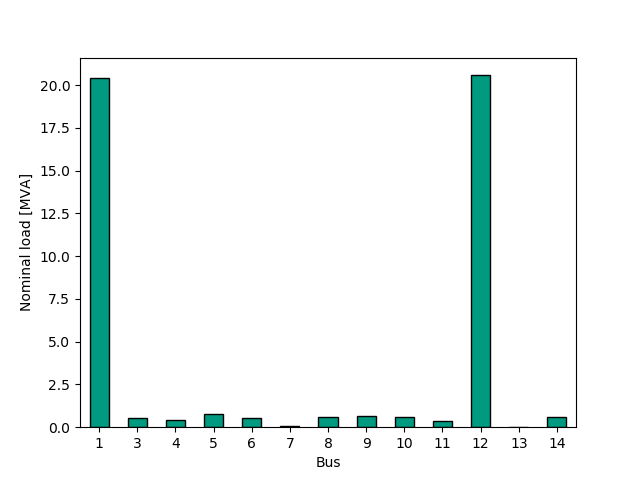

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

In [55]:
fig,ax = plt.subplots()
env = ActiveEnv()
net = env.powergrid
nominal_load = net.load[['name','bus','sn_kva']]
nominal_load = nominal_load.groupby('bus').sum()
nominal_load['Load share'] = nominal_load['sn_kva'] / nominal_load['sn_kva'].sum() * 100
nominal_load['sn_kva'] = nominal_load['sn_kva'].astype('int')
nominal_load['sn_kva'] /= 1000
nominal_load['sn_kva'].plot(kind='bar', ax=ax, color=palette[0],linewidth=1,edgecolor="k")
ax.set_ylabel('Nominal load [MVA]')
ax.set_xlabel('Bus')
plt.xticks(rotation=0)


#nominal_load.to_csv('data/nominal_load.csv',float_format='%.1f')
#pickle_savefig(fig,'nominal_load')

## Nominal sgen values
See the difference in nominal loads between the loads

<IPython.core.display.Javascript object>


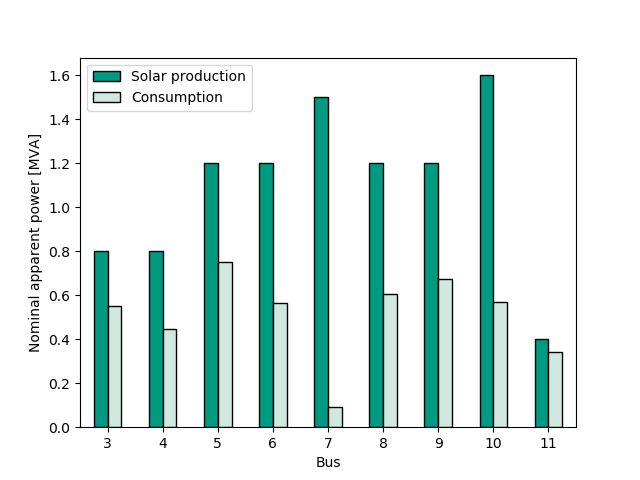

In [139]:
sns.set_palette(palette)
fig,ax = plt.subplots()
net = env.powergrid
nominal_sgen = net.sgen[['name','bus','sn_kva']]
nominal_sgen = nominal_sgen.groupby('bus').sum()
nominal_sgen['Load share'] = nominal_sgen['sn_kva'] / nominal_sgen['sn_kva'].sum() * 100
nominal_sgen['Solar production'] = nominal_sgen['sn_kva'].astype('int')
nominal_sgen['Solar production'] /= 1000
nominal_sgen['Consumption'] = nominal_load['sn_kva']
#data = stack_columns(nominal_sgen,columns=['Solar production','Consumption'])
nominal_sgen[['Solar production','Consumption']].plot(kind='bar', ax=ax, edgecolor="k")

ax.set_ylabel('Nominal apparent power [MVA]')
ax.set_xlabel('Bus')
plt.xticks(rotation=0)

#nominal_load.to_csv('data/nominal_sgen.csv',float_format='%.1f')
#pickle_savefig(fig,'nominal_sgen')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

In [497]:
nominal_sgen.iloc[:,-2] / nominal_sgen.iloc[:,-1]

bus
3      1.454545
4      1.797753
5      1.600000
6      2.123894
7     16.666667
8      1.983471
9      1.777778
10     2.807018
11     1.176471
dtype: float64

## See actions of agent at buses with a high implact

In [58]:
def simulate_day3(env, model, show_imbalance=False, show_solar=True,
                  show_action=True,
                  show_demand=False, period=25):
    """
    simulate grid and save info about action of each bus, hour of day etc.
    :param env:
    :param model:
    :param show_imbalance:
    :param show_solar:
    :param show_action:
    :param show_demand:
    :param period:
    :return:
    """
    net = env.powergrid
    actions, t_steps, flex_loads, sols, hours = [], [], [], [], []

    obs = env.reset()
    sol = env.solar_forecasts
    demand = env.demand_forecasts[0]
    hues = []
    for t_step in range(1, period):

        action, _ = model.predict(obs)
        obs, rewards, dones, info = env.step(action)
        
        
        if env._current_step == 0:
            sol = env.solar_forecasts
            demand = env.demand_forecasts[0]

        if show_action:
            actions += list(action)
            hues += ['action' for _ in range(len(action))]
            t_steps += list(t_step * np.ones_like(action))
            flex_loads += list(net.load.index)

        if show_solar:
            actions += list(sol[env._current_step - 1] * np.ones_like(action))
            hues += ['sun' for _ in range(len(action))]
            t_steps += list(t_step * np.ones_like(action))
            flex_loads += list(net.load.index)
        if show_imbalance:
            try:
                imbalance = env.calc_balance() / 30000
            except AttributeError:
                imbalance = env.calc_imbalance() / 30000
            actions += list(imbalance * np.ones_like(action))
            hues += ['imbalance' for _ in range(len(action))]
            t_steps += list(t_step * np.ones_like(action))
            flex_loads += list(net.load.index)

        if show_demand:
            actions += list(demand[env._current_step - 1] * np.ones_like(action))
            hues += ['demand' for _ in range(len(action))]
            t_steps += list(t_step * np.ones_like(action))
            flex_loads += list(net.load.index)

        hour = calc_hour(env._episode_start_hour, env._current_step)
        hours += [hour for _ in range(len(action)*3)]

    df = pd.DataFrame()
    df['actions'] = actions
    df['steps'] = t_steps
    df['load'] = flex_loads
    df['hour'] = hours
    df[''] = hues
    return df

In [57]:
def shift_hour(x):
    if x == 0:
        return 23
    else:
        return x-1
    

In [178]:
model, env = load_env('800k_full',seed=9)
df = simulate_day3(env,model, show_demand=True, period=100000)

Loading a model without an environment, this model cannot be trained until it has a valid environment.
setting up target updates ...
  target/pi/fc0/kernel:0 <- model/pi/fc0/kernel:0
  target/pi/fc0/bias:0 <- model/pi/fc0/bias:0
  target/pi/LayerNorm/beta:0 <- model/pi/LayerNorm/beta:0
  target/pi/LayerNorm/gamma:0 <- model/pi/LayerNorm/gamma:0
  target/pi/fc1/kernel:0 <- model/pi/fc1/kernel:0
  target/pi/fc1/bias:0 <- model/pi/fc1/bias:0
  target/pi/LayerNorm_1/beta:0 <- model/pi/LayerNorm_1/beta:0
  target/pi/LayerNorm_1/gamma:0 <- model/pi/LayerNorm_1/gamma:0
  target/pi/pi/kernel:0 <- model/pi/pi/kernel:0
  target/pi/pi/bias:0 <- model/pi/pi/bias:0
  target/qf/fc0/kernel:0 <- model/qf/fc0/kernel:0
  target/qf/fc0/bias:0 <- model/qf/fc0/bias:0
  target/qf/LayerNorm/beta:0 <- model/qf/LayerNorm/beta:0
  target/qf/LayerNorm/gamma:0 <- model/qf/LayerNorm/gamma:0
  target/qf/fc1/kernel:0 <- model/qf/fc1/kernel:0
  target/qf/fc1/bias:0 <- model/qf/fc1/bias:0
  target/qf/LayerNorm_1/beta:

In [179]:
#df.to_csv('data/800k_full_actions.csv',index=False)

In [125]:
#df = pd.read_csv('data/config1_actions.csv')
df = df.rename(columns={'Unnamed: 4': ''})
#df['hour'] = df['hour'].apply(lambda x:shift_hour(x))

In [62]:
df[(df['load'] == 0) & (df['']=='action')].head()

,actions,steps,load,hour,
0,-0.999872,1.0,0,19,action
54,-1.000000,2.0,0,20,action
108,-1.000000,3.0,0,21,action
162,0.999807,4.0,0,22,action
216,0.999998,5.0,0,23,action


<IPython.core.display.Javascript object>


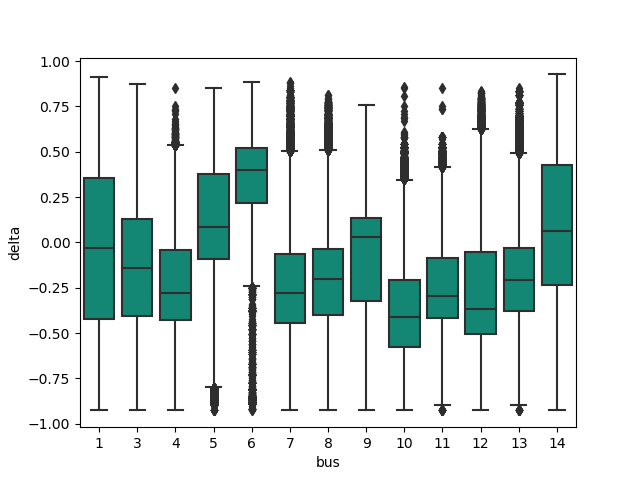

In [182]:
load_bus = dict(zip(net.load.index,net.load.bus))


data = df[df[''] == 'action']
demand =  df[df[''] == 'demand']
assert  (data[['steps','load']] .values == demand[['steps','load']] .values).all()

data['delta'] = data['actions']*demand['actions'].values
data['bus'] = data['load'].apply(lambda x: load_bus[x])
fig, ax = plt.subplots()
sns.boxplot(x='bus',y='delta', data=data, ax=ax, color=palette[0])

### group power change by hour

<IPython.core.display.Javascript object>


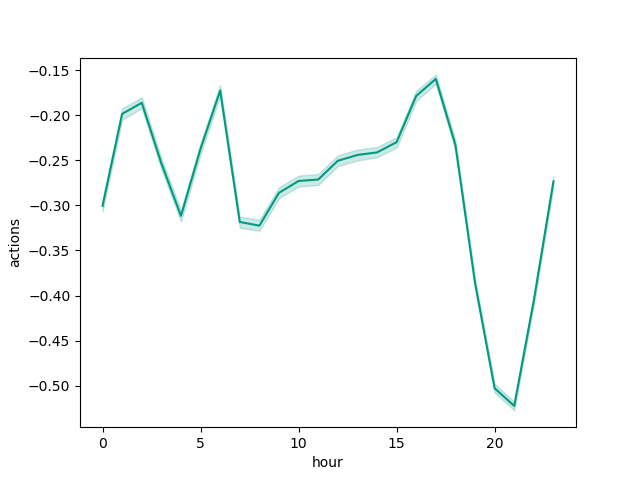

In [183]:
fig, ax = plt.subplots()
sns.lineplot(x = 'hour', y='actions', data=data, ax=ax)

In [127]:
ax.set_xlabel('Hour of the day')
ax.set_ylabel('Change in demand')
plt.tight_layout()

In [128]:
#pickle_savefig(fig,'config1_action_hour')

In [367]:
env.demand_data.max()

demand    0.092665
dtype: float64

### Mean action by buses

<IPython.core.display.Javascript object>


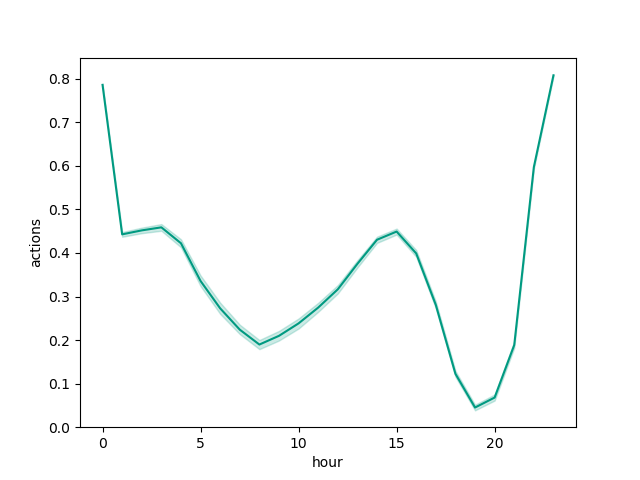

In [113]:
fig, ax = plt.subplots()
sns.lineplot(x = 'hour', y='actions', data=data[data['bus']==3], ax=ax)

In [492]:
df[df[''] == 'demand'].groupby('hour')['actions'].describe()

,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
0,74700.0,0.386105,0.041172,0.271122,0.358531,0.385242,0.413740,0.527162
1,74772.0,0.055299,0.038361,-0.014023,0.037789,0.051161,0.065660,0.534712
2,74808.0,0.060735,0.040882,-0.020140,0.040182,0.061046,0.077871,0.638822
3,74862.0,0.072861,0.047983,-0.017117,0.048648,0.071174,0.090501,0.697577
4,74934.0,0.097670,0.050744,-0.000590,0.073237,0.094033,0.119154,0.686818
5,74952.0,0.129044,0.054566,0.014962,0.102251,0.125526,0.155400,0.831313
6,75114.0,0.189921,0.067826,0.016107,0.157193,0.190610,0.218940,0.849485
7,75132.0,0.300650,0.060593,0.148203,0.258869,0.297269,0.332825,0.926647
8,75222.0,0.346596,0.056082,0.242496,0.312802,0.343317,0.374025,0.851338


In [380]:
env.demand_data.idxmax()

demand   2004-06-14 19:00:00
dtype: datetime64[ns]

<IPython.core.display.Javascript object>


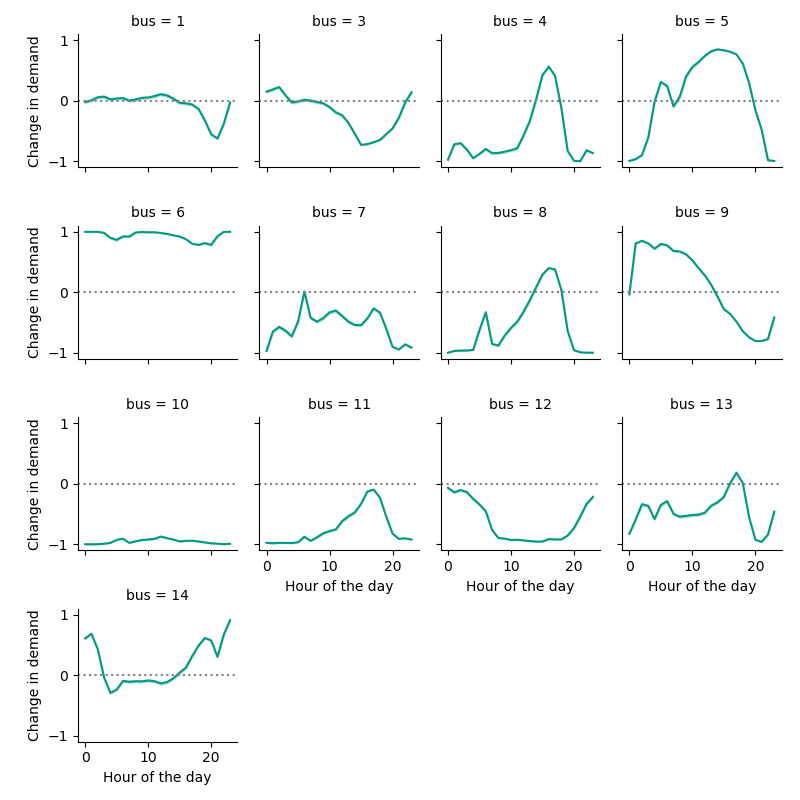

In [184]:
g = sns.FacetGrid(data, col="bus", col_wrap=4, height=2)

g = g.map(sns.lineplot,"hour","actions")
g = g.map(plt.axhline, y=0, ls=":", c=".5")
g.set_ylabels('Change in demand')
g.set_xlabels('Hour of the day')
plt.tight_layout()


In [130]:
#pickle_savefig(g,'config1_action_bus')